In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score


from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.model_selection import train_test_split
import joblib

In [26]:
def display_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm).plot()

# Downloading the data and its observing

In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False, parser = 'auto')

X = mnist["data"]
y = mnist["target"].astype(np.uint8)

In [4]:
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [5]:
# Taking less data to speed up training. 
X_train = X[:5000]
y_train = y[:5000]
X_val = X[5000:6000]
y_val = y[5000:6000]

X_test = X[6000:7000]
y_test = y[6000:7000]

# Standardizing the data (as you generally always should do when using SVM models).
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)  # Only transforming the validation data. 
X_test_scaled = scaler.transform(X_test)  # Only transforming the test data. 

In [6]:
# The first label ("true answer") is 5. 
y[0]

5

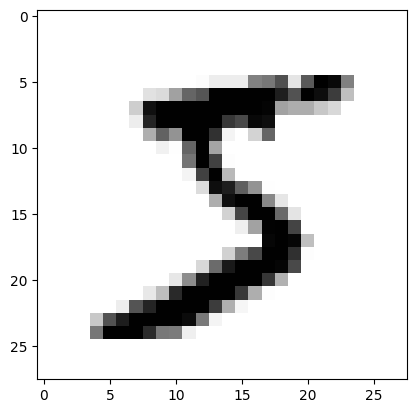

In [8]:
# Plotting the features of the X data, it looks like a 5.
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
# plt.axis("off")

In [9]:
print(X_train.shape)
print(y_train.shape)

(5000, 784)
(5000,)


# Creating models and evaluating them on the validation set

### LinearSVC

In [10]:
#Creating and fitting the LinearSVC model
lin_clf = LinearSVC(random_state=42)
lin_clf.fit(X_train_scaled, y_train)

C:\Users\kamif\anaconda3\envs\streamlitenv\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\kamif\anaconda3\envs\streamlitenv\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(random_state=42)

In [11]:
#Creating and fitting the KNN neighbor model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)



KNeighborsClassifier()

In [12]:
# Predicting the scaled validation data.
y_pred_linear = lin_clf.predict(X_val_scaled)

#Compute accuracy score, use the imported functionality:
accuracy_score(y_val, y_pred_linear)

0.844

In [13]:
# Predicting the scaled validation data.
y_pred_knn = knn.predict(X_val_scaled)

#Compute accuracy score, use the imported functionality:
accuracy_score(y_val, y_pred_knn)

0.905

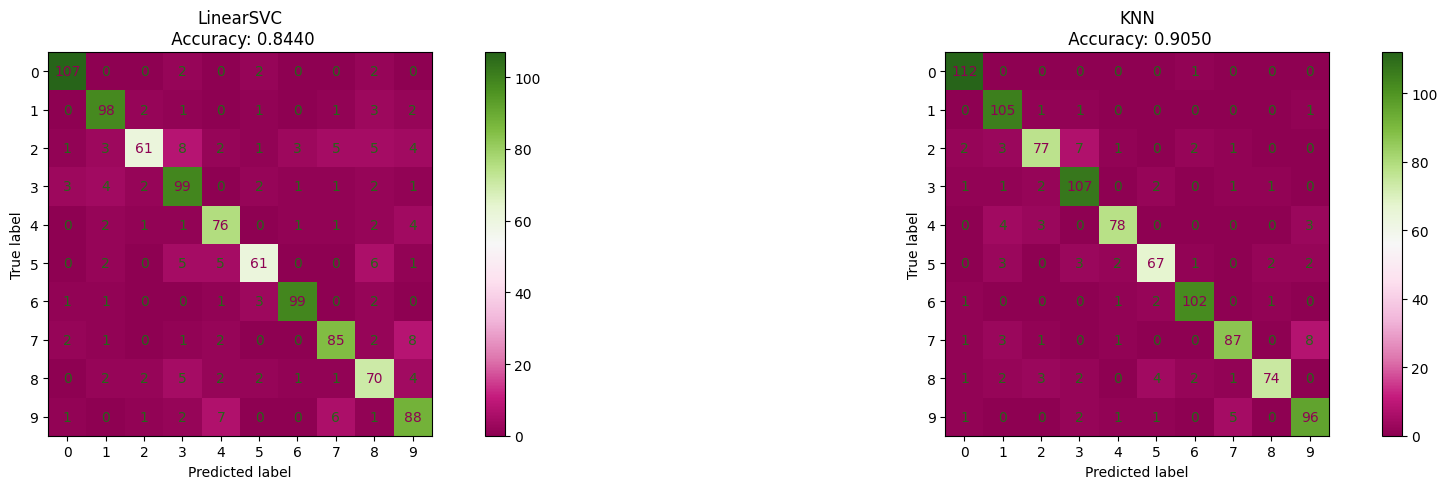

In [23]:
# Calculate accuracy and matrices for each classifier
classifiers = ["LinearSVC", "KNN"]
accuracies = []
confusion_matrices = []

for classifier, y_pred in zip(classifiers, [y_pred_linear, y_pred_knn]):
    accuracy = accuracy_score(y_val, y_pred)
    cm = confusion_matrix(y_val, y_pred)
    accuracies.append(accuracy)
    confusion_matrices.append(cm)


fig, ax = plt.subplots(1, 2, figsize=(20, 5))

for idx, (classifier, accuracy, cm) in enumerate(zip(classifiers, accuracies, confusion_matrices)):
    ax[idx].set_title(f"{classifier}\n Accuracy: {accuracy:.4f}")
    ConfusionMatrixDisplay(cm).plot(ax=ax[idx], cmap='PiYG')

plt.tight_layout()
plt.show()

## Since the KNN model gives better results, we tune it with the GridSearch 

In [15]:
### K-Nearest Neighbors tuning
estimator_KNN = KNeighborsClassifier(algorithm='auto')
parameters_KNN = {
    'leaf_size': (20,40,1),
    'metric': ('minkowski', 'chebyshev'),
    'n_neighbors': (1,10, 1),
    'p': (1,2),
    'weights': ('uniform', 'distance')
   }


# GridSearch
grid_search_KNN = GridSearchCV(
    estimator=estimator_KNN,
    param_grid=parameters_KNN,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = 5
)


# find best params
gs_knn = GridSearchCV(estimator=knn, param_grid=parameters_KNN, scoring='accuracy', cv=3)
gs_knn.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': (20, 40, 1),
                         'metric': ('minkowski', 'chebyshev'),
                         'n_neighbors': (1, 10, 1), 'p': (1, 2),
                         'weights': ('uniform', 'distance')},
             scoring='accuracy')

In [16]:
print("Best parameters:", parameters_KNN)

Best parameters: {'leaf_size': (20, 40, 1), 'metric': ('minkowski', 'chebyshev'), 'n_neighbors': (1, 10, 1), 'p': (1, 2), 'weights': ('uniform', 'distance')}


In [17]:
print(gs_knn.best_params_ ) 

{'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}


In [18]:
print("Best CV accuracy", gs_knn.best_score_)

Best CV accuracy 0.8964010319184662


In [19]:
pd.DataFrame(gs_knn.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_leaf_size,param_metric,param_n_neighbors,param_p,param_weights,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.018970,0.000223,1.467602,0.034474,20,minkowski,1,1,uniform,"{'leaf_size': 20, 'metric': 'minkowski', 'n_ne...",0.887822,0.899820,0.901561,0.896401,0.006107,1
1,0.017974,0.004062,1.210462,0.028206,20,minkowski,1,1,distance,"{'leaf_size': 20, 'metric': 'minkowski', 'n_ne...",0.887822,0.899820,0.901561,0.896401,0.006107,1
2,0.021511,0.002494,0.098397,0.013615,20,minkowski,1,2,uniform,"{'leaf_size': 20, 'metric': 'minkowski', 'n_ne...",0.863827,0.889022,0.872749,0.875200,0.010431,22
3,0.016443,0.002911,0.086422,0.010741,20,minkowski,1,2,distance,"{'leaf_size': 20, 'metric': 'minkowski', 'n_ne...",0.863827,0.889022,0.872749,0.875200,0.010431,22
4,0.019168,0.002730,1.433724,0.012151,20,minkowski,10,1,uniform,"{'leaf_size': 20, 'metric': 'minkowski', 'n_ne...",0.873425,0.901020,0.882953,0.885799,0.011444,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,0.019393,0.000206,1.164862,0.024941,1,chebyshev,10,2,distance,"{'leaf_size': 1, 'metric': 'chebyshev', 'n_nei...",0.593881,0.628674,0.645858,0.622805,0.021622,61
68,0.013533,0.000523,1.260966,0.076320,1,chebyshev,1,1,uniform,"{'leaf_size': 1, 'metric': 'chebyshev', 'n_nei...",0.605879,0.647271,0.636855,0.630001,0.017579,37
69,0.023100,0.001088,1.575170,0.171505,1,chebyshev,1,1,distance,"{'leaf_size': 1, 'metric': 'chebyshev', 'n_nei...",0.605879,0.647271,0.636855,0.630001,0.017579,37
70,0.018790,0.002540,1.480161,0.285255,1,chebyshev,1,2,uniform,"{'leaf_size': 1, 'metric': 'chebyshev', 'n_nei...",0.605879,0.647271,0.636855,0.630001,0.017579,37


In [20]:
#Prediction on the GridSearch parameters on validation data

y_pred_gs_knn = gs_knn.predict(X_val_scaled)
accuracy_score(y_val, y_pred_gs_knn)

0.923

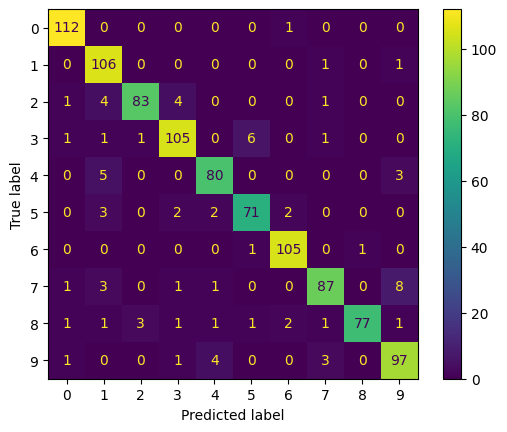

In [21]:
display_confusion_matrix(y_val, y_pred_gs_knn)

## Make a prediction based on the gridsearch best parameters

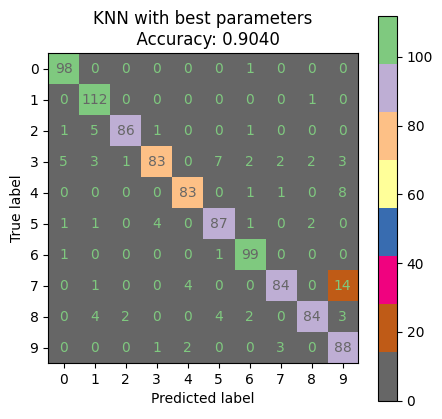

In [31]:
# prediction - Best Parameters: {'leaf_size': 20, 'metric': 'minkowski', 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
#bestC = 1
#bestG = 0.001


# Run new fit with best parameters
knn_final = KNeighborsClassifier(
    leaf_size = 20,
    metric = 'minkowski',
    n_neighbors = 1,
    p = 1,
    weights = 'uniform'
    )   
   
knn_final.fit(X_train_scaled, y_train)
y_pred_test = knn_final.predict(X_test_scaled)

accuracysc = accuracy_score(y_test, y_pred_test)

# plot it on confusion matrix
fig, ax = plt.subplots(1, 1, figsize=(5, 5)) 
ax.set_title(f"KNN with best parameters\n  Accuracy: {accuracysc:.4f}")

cm = confusion_matrix(y_test, y_pred_test)
ConfusionMatrixDisplay(cm).plot(ax=ax, cmap='Accent_r')
plt.show()

## Save the model

In [27]:
# Save the model
joblib.dump(knn_final, "knn_model.pkl") 


['knn_model.pkl']